In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import pathlib
import pickle
import statsmodels
import itertools
import time

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from statistics import mode
from itertools import product
from scipy.stats import skew, kurtosis, ttest_rel
from scipy.signal import butter, welch, filtfilt, resample
from scipy import interp, stats

from sklearn.metrics import confusion_matrix, auc, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, roc_auc_score

from PreprocessFcns import *

%matplotlib inline

sns.set_context('poster',font_scale=1)

In [2]:
time.sleep(3600*10)

In [3]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            ######
            
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)

#             f, t, th = roc_curve(yte,yscore)
#             print(auroc,auc(f,t))

            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres

def LOSOCV_Multi(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)

            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            ######
            
            yscore = clf.predict_proba(Xte)
            if len(np.unique(yte))>1:
                yte_bin = label_binarize(yte, clf.classes_)
                for c in list(range(yte_bin.shape[1]))[::-1]:
                    if not any(yte_bin[:,c]):
                        yte_bin = np.delete(yte_bin,[c],axis=1)
                        yscore = np.delete(yscore,[c],axis=1)
                        
                auroc = roc_auc_score(yte_bin,yscore,average='weighted')
                fpr_mean = np.array(range(0,101))/100
                tprs = []
                for i in range(yte_bin.shape[1]):
                    yt = yte_bin[:,i]
                    ys = yscore[:,i]
                    
#                     fpr=np.linspace(0,1,101); tpr=[]
# 
#                     if len(np.unique(yte))>1:                
#                         nscores = np.sort(np.column_stack((ys[yt==0],yt[yt==0])),axis=0)
#                         neg_counts = sum(yt==0)
#                         for f in fpr:
#                             ind = neg_counts-int(neg_counts*f)-1
#                             t = (nscores[ind])[0]
#                             print(t)
#                             if f==1:
#                                 t = 0
#                             tpr_t = sum(ys[yt==1]>t) / sum(yt==1)
#                             tpr.append(tpr_t) 

#                     print(auc(fpr,tpr),roc_auc_score(yt,ys))
#                     print(fpr, tpr)
                            
#                     fpr = np.asarray(fpr); tpr = np.asarray(tpr)*np.mean(yt)
#                     fpr_all.append(fpr); tpr_all.append(tpr)
                    
                    
                    
                    fpr, tpr, thresh = roc_curve(yte_bin[:,i],yscore[:,i],pos_label=1)
#                     print(min(yscore[yte_bin[:,i]==1,i]),max(yscore[yte_bin[:,i]==0,i]))
#                     print(fpr,tpr,thresh)
#                     print(auc(fpr,tpr),roc_auc_score(yte_bin[:,i],yscore[:,i]))
                    tprs.append(interp(fpr_mean,fpr,tpr)*np.mean(yte_bin[:,i]))
                tpr = sum(tprs)
#                 print(tpr)
                fpr = fpr_mean
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
                fpr = np.array([])
                tpr = np.array([])
            
            tpr_all.append(tpr)
            fpr_all.append(fpr)
            auroc_all.append(auroc)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d,auroc=%.3f'%(s,auroc))
            s+=1

        print('auroc=%.3f+/-%.3f'%(np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'tpr':tpr_all, 'fpr':fpr_all, 'auroc': auroc_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
        
    return results,groupres

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None,ls='-',lw=3):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=lw,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=lw,linestyle=ls)
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [4]:
# gr = LOSOCV_Multi(Data,X,y,groups,models)

# Accelerometer and Gyroscope Comparisons

## Tremor

In [5]:
# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# # Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv',index_col = 0)
# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

In [6]:
#LOSO Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:79].as_matrix()
fnames = Data.iloc[:,5:79].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Accel = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.187,rec=0.272,Spec=0.903,auroc_train=1.000,auroc=0.715

Subj/Visit 1,prec=0.663,rec=0.112,Spec=0.965,auroc_train=1.000,auroc=0.719

Subj/Visit 2,prec=0.658,rec=0.361,Spec=0.962,auroc_train=1.000,auroc=0.849

Subj/Visit 3,prec=0.226,rec=0.541,Spec=0.881,auroc_train=1.000,auroc=0.766

Subj/Visit 4,prec=0.481,rec=0.221,Spec=0.891,auroc_train=1.000,auroc=0.720

Subj/Visit 5,prec=0.667,rec=0.361,Spec=0.851,auroc_train=1.000,auroc=0.728

Subj/Visit 6,prec=0.663,rec=0.568,Spec=0.970,auroc_train=1.000,auroc=0.923

Subj/Visit 7,prec=0.519,rec=0.359,Spec=0.983,auroc_train=1.000,auroc=0.909

Subj/Visit 8,prec=0.916,rec=0.604,Spec=0.942,auroc_train=1.000,auroc=0.878


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.893,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.265,rec=0.026,Spec=0.942,auroc_train=1.000,auroc=0.275

Subj/Visit 11,prec=0.948,rec=0.563,Spec=0.887,auroc_train=1.000,auroc=0.854

Subj/Visit 12,prec=0.008,rec=0.143,Spec=0.890,auroc_train=1.000,auroc=0.808
f1_test=0.346+/-0.239, prec=0.477+/-0.303, rec=0.318+/-0.202, auprc=0.492+/-0.265, auroc=0.762+/-0.164
Elapsed time = 1.301 min


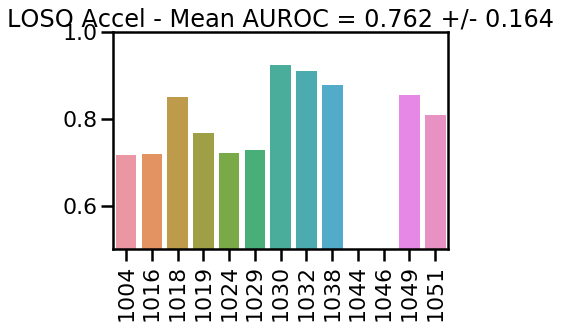

In [7]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOAccel_Hand.png',format='png',dpi=1000)

In [8]:
#LOSO Gyroscope Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,79:].as_matrix()
fnames = Data.iloc[:,79:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Gyro = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.166,rec=0.380,Spec=0.843,auroc_train=1.000,auroc=0.730

Subj/Visit 1,prec=0.748,rec=0.163,Spec=0.966,auroc_train=1.000,auroc=0.793

Subj/Visit 2,prec=0.672,rec=0.406,Spec=0.960,auroc_train=1.000,auroc=0.774

Subj/Visit 3,prec=0.268,rec=0.459,Spec=0.919,auroc_train=1.000,auroc=0.781

Subj/Visit 4,prec=0.569,rec=0.208,Spec=0.928,auroc_train=1.000,auroc=0.728

Subj/Visit 5,prec=0.701,rec=0.415,Spec=0.854,auroc_train=1.000,auroc=0.769

Subj/Visit 6,prec=0.748,rec=0.721,Spec=0.975,auroc_train=1.000,auroc=0.924

Subj/Visit 7,prec=0.600,rec=0.692,Spec=0.976,auroc_train=1.000,auroc=0.909

Subj/Visit 8,prec=0.917,rec=0.550,Spec=0.948,auroc_train=1.000,auroc=0.875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.838,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.777,rec=0.217,Spec=0.950,auroc_train=1.000,auroc=0.617

Subj/Visit 11,prec=0.943,rec=0.574,Spec=0.873,auroc_train=1.000,auroc=0.854

Subj/Visit 12,prec=0.012,rec=0.286,Spec=0.850,auroc_train=1.000,auroc=0.835
f1_test=0.408+/-0.239, prec=0.548+/-0.314, rec=0.390+/-0.205, auprc=0.572+/-0.266, auroc=0.799+/-0.083
Elapsed time = 1.380 min


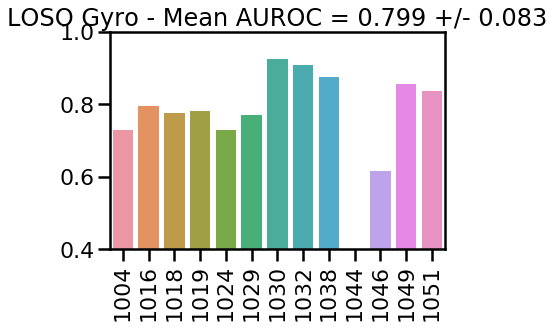

In [9]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOGyro_Hand.png',format='png',dpi=1000)

In [10]:
#LOSO Combined Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Comb = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.201,rec=0.337,Spec=0.890,auroc_train=1.000,auroc=0.733

Subj/Visit 1,prec=0.705,rec=0.151,Spec=0.961,auroc_train=1.000,auroc=0.773

Subj/Visit 2,prec=0.619,rec=0.322,Spec=0.960,auroc_train=1.000,auroc=0.821

Subj/Visit 3,prec=0.253,rec=0.500,Spec=0.905,auroc_train=1.000,auroc=0.799

Subj/Visit 4,prec=0.497,rec=0.183,Spec=0.915,auroc_train=1.000,auroc=0.725

Subj/Visit 5,prec=0.671,rec=0.402,Spec=0.838,auroc_train=1.000,auroc=0.751

Subj/Visit 6,prec=0.811,rec=0.775,Spec=0.981,auroc_train=1.000,auroc=0.948

Subj/Visit 7,prec=0.585,rec=0.615,Spec=0.977,auroc_train=1.000,auroc=0.929

Subj/Visit 8,prec=0.913,rec=0.595,Spec=0.940,auroc_train=1.000,auroc=0.885


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.854,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.327,rec=0.032,Spec=0.947,auroc_train=1.000,auroc=0.391

Subj/Visit 11,prec=0.948,rec=0.623,Spec=0.877,auroc_train=1.000,auroc=0.862

Subj/Visit 12,prec=0.006,rec=0.143,Spec=0.848,auroc_train=1.000,auroc=0.679
f1_test=0.382+/-0.266, prec=0.503+/-0.308, rec=0.360+/-0.239, auprc=0.552+/-0.269, auroc=0.775+/-0.141
Elapsed time = 1.947 min


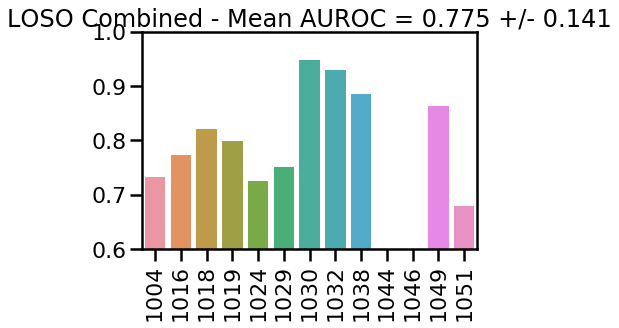

In [11]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOCombined_Hand.png',format='png',dpi=1000)

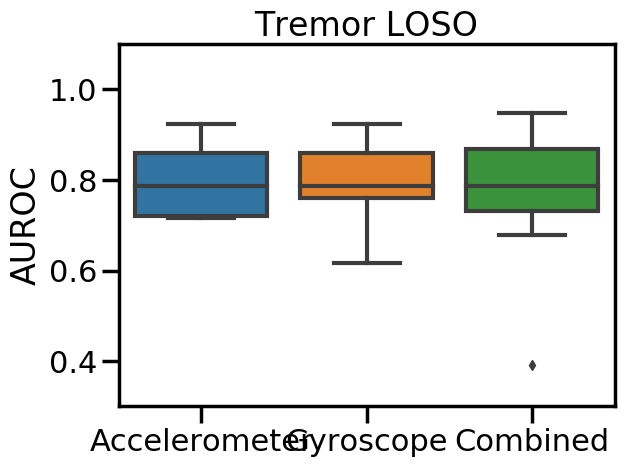

In [12]:
resultsAccel = np.load('Results/resultsTremorLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsTremorLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsTremorLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Tremor LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

## Bradykinesia

In [13]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)
# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

In [14]:
#LOSO Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:79].as_matrix()
fnames = Data.iloc[:,5:79].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Accel = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 6697/12184 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.292,rec=0.505,Spec=0.544,auroc_train=1.000,auroc=0.548

Subj/Visit 1,prec=0.924,rec=0.763,Spec=0.655,auroc_train=1.000,auroc=0.756

Subj/Visit 2,prec=0.923,rec=0.784,Spec=0.645,auroc_train=1.000,auroc=0.757

Subj/Visit 3,prec=0.604,rec=0.914,Spec=0.286,auroc_train=1.000,auroc=0.580

Subj/Visit 4,prec=0.782,rec=0.692,Spec=0.703,auroc_train=1.000,auroc=0.767

Subj/Visit 5,prec=0.758,rec=0.625,Spec=0.720,auroc_train=1.000,auroc=0.713

Subj/Visit 6,prec=0.750,rec=0.935,Spec=0.407,auroc_train=1.000,auroc=0.735

Subj/Visit 7,prec=0.814,rec=0.635,Spec=0.469,auroc_train=1.000,auroc=0.535

Subj/Visit 8,prec=0.079,rec=0.633,Spec=0.362,auroc_train=1.000,auroc=0.496

Subj/Visit 9,prec=0.089,rec=0.939,Spec=0.469,auroc_train=1.000,auroc=0.740

Subj/Visit 10,prec=0.499,rec=0.391,Spec=0.516,auroc_train=1.000,auroc=0.459

Subj/Visit 11,prec=0.902,rec=0.437,Spec=0.656,auroc_train=1.000,auroc=0.549

Subj/Visit 12,prec=0.417

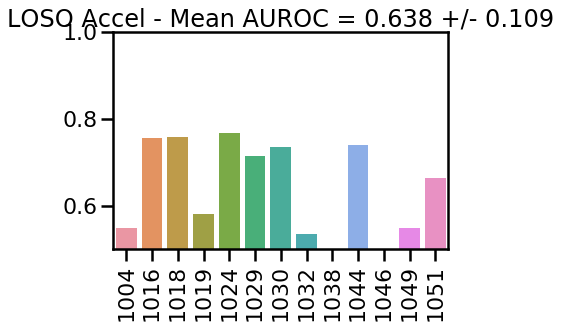

In [15]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOAccel_Hand.png',format='png',dpi=1000)

In [16]:
#LOSO Gyroscope Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,79:].as_matrix()
fnames = Data.iloc[:,79:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Gyro = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 6697/12184 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.367,rec=0.779,Spec=0.499,auroc_train=1.000,auroc=0.692

Subj/Visit 1,prec=0.939,rec=0.762,Spec=0.730,auroc_train=1.000,auroc=0.830

Subj/Visit 2,prec=0.937,rec=0.893,Spec=0.674,auroc_train=1.000,auroc=0.833

Subj/Visit 3,prec=0.606,rec=0.950,Spec=0.265,auroc_train=1.000,auroc=0.596

Subj/Visit 4,prec=0.757,rec=0.640,Spec=0.684,auroc_train=1.000,auroc=0.721

Subj/Visit 5,prec=0.683,rec=0.625,Spec=0.593,auroc_train=1.000,auroc=0.632

Subj/Visit 6,prec=0.753,rec=0.924,Spec=0.424,auroc_train=1.000,auroc=0.780

Subj/Visit 7,prec=0.889,rec=0.692,Spec=0.683,auroc_train=1.000,auroc=0.768

Subj/Visit 8,prec=0.090,rec=0.684,Spec=0.406,auroc_train=1.000,auroc=0.538

Subj/Visit 9,prec=0.092,rec=0.980,Spec=0.463,auroc_train=1.000,auroc=0.770

Subj/Visit 10,prec=0.630,rec=0.568,Spec=0.591,auroc_train=1.000,auroc=0.611

Subj/Visit 11,prec=0.871,rec=0.471,Spec=0.492,auroc_train=1.000,auroc=0.458

Subj/Visit 12,prec=0.391

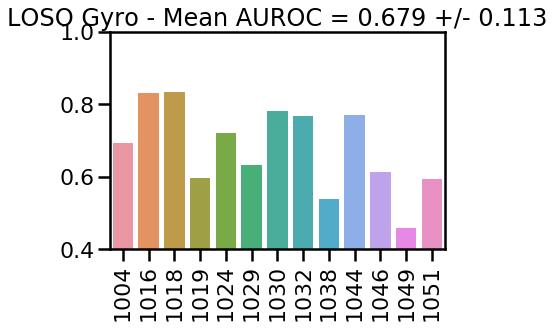

In [17]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOGyro_Hand.png',format='png',dpi=1000)

In [18]:
#LOSO Combined Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Comb = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 6697/12184 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.375,rec=0.739,Spec=0.543,auroc_train=1.000,auroc=0.698

Subj/Visit 1,prec=0.925,rec=0.787,Spec=0.649,auroc_train=1.000,auroc=0.812

Subj/Visit 2,prec=0.945,rec=0.867,Spec=0.725,auroc_train=1.000,auroc=0.814

Subj/Visit 3,prec=0.604,rec=0.940,Spec=0.265,auroc_train=1.000,auroc=0.610

Subj/Visit 4,prec=0.805,rec=0.670,Spec=0.750,auroc_train=1.000,auroc=0.778

Subj/Visit 5,prec=0.743,rec=0.643,Spec=0.687,auroc_train=1.000,auroc=0.687

Subj/Visit 6,prec=0.751,rec=0.952,Spec=0.401,auroc_train=1.000,auroc=0.802

Subj/Visit 7,prec=0.829,rec=0.687,Spec=0.481,auroc_train=1.000,auroc=0.658

Subj/Visit 8,prec=0.079,rec=0.608,Spec=0.387,auroc_train=1.000,auroc=0.514

Subj/Visit 9,prec=0.093,rec=0.959,Spec=0.482,auroc_train=1.000,auroc=0.788

Subj/Visit 10,prec=0.543,rec=0.465,Spec=0.519,auroc_train=1.000,auroc=0.507

Subj/Visit 11,prec=0.889,rec=0.424,Spec=0.615,auroc_train=1.000,auroc=0.532

Subj/Visit 12,prec=0.415

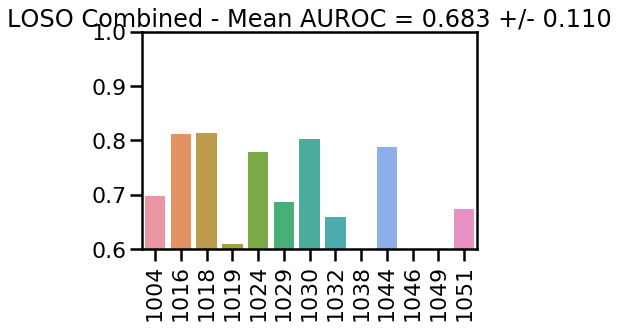

In [19]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOCombined_Hand.png',format='png',dpi=1000)

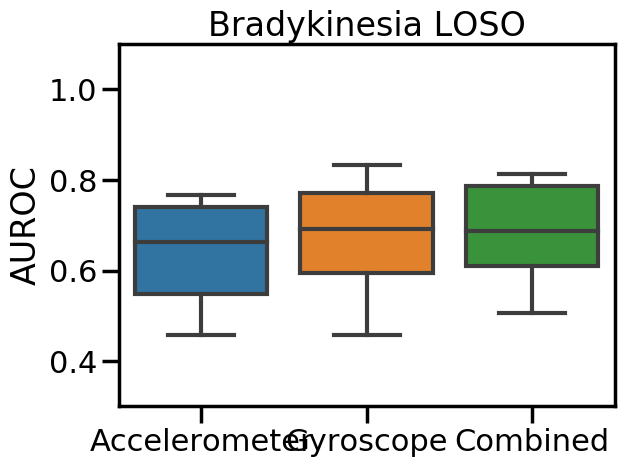

In [20]:
resultsAccel = np.load('Results/resultsBradykinesiaLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsBradykinesiaLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

# Smartwatch Comparisons

## Tremor

In [21]:
#Hand Sensors

# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'

# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:79]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) | 
                        (Dataorig.Subject==1016) | 
                        (Dataorig.Subject==1018) | 
                        (Dataorig.Subject==1019) | 
#                        (Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) | 
                        (Dataorig.Subject==1029) | 
                        (Dataorig.Subject==1030) | 
                        (Dataorig.Subject==1032) | 
                        (Dataorig.Subject==1038) | 
                        (Dataorig.Subject==1044) | 
                        (Dataorig.Subject==1046) | 
                        (Dataorig.Subject==1049) | 
                        (Dataorig.Subject==1051)]

# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc'], inplace=True)


t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.188,rec=0.239,Spec=0.915,auroc_train=1.000,auroc=0.711

Subj/Visit 1,prec=0.674,rec=0.122,Spec=0.963,auroc_train=1.000,auroc=0.719

Subj/Visit 2,prec=0.636,rec=0.312,Spec=0.964,auroc_train=1.000,auroc=0.838

Subj/Visit 3,prec=0.230,rec=0.554,Spec=0.881,auroc_train=1.000,auroc=0.766

Subj/Visit 4,prec=0.489,rec=0.221,Spec=0.894,auroc_train=1.000,auroc=0.727

Subj/Visit 5,prec=0.681,rec=0.389,Spec=0.850,auroc_train=1.000,auroc=0.735

Subj/Visit 6,prec=0.670,rec=0.532,Spec=0.973,auroc_train=1.000,auroc=0.928

Subj/Visit 7,prec=0.580,rec=0.372,Spec=0.986,auroc_train=1.000,auroc=0.910

Subj/Visit 8,prec=0.936,rec=0.595,Spec=0.957,auroc_train=1.000,auroc=0.884


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.880,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.288,rec=0.030,Spec=0.940,auroc_train=1.000,auroc=0.303

Subj/Visit 11,prec=0.946,rec=0.574,Spec=0.880,auroc_train=1.000,auroc=0.849

Subj/Visit 12,prec=0.008,rec=0.143,Spec=0.885,auroc_train=1.000,auroc=0.809
f1_test=0.348+/-0.238, prec=0.487+/-0.305, rec=0.314+/-0.200, auprc=0.490+/-0.266, auroc=0.765+/-0.157
Elapsed time = 1.302 min


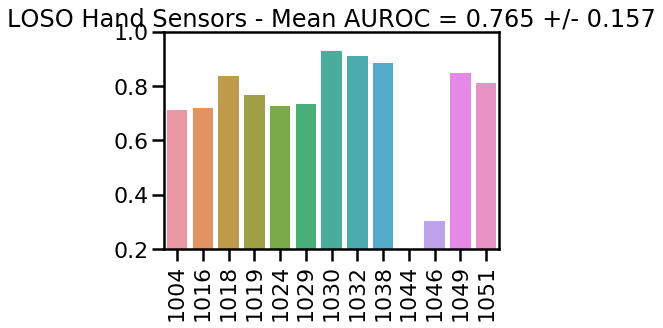

In [22]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorHand.png',format='png',dpi=1000)

In [23]:
# Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
# Dataorig.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Watch = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 3755/14164 = 0.27
Training Random Forest

Subj/Visit 0,prec=0.247,rec=0.484,Spec=0.855,auroc_train=1.000,auroc=0.729

Subj/Visit 1,prec=0.795,rec=0.204,Spec=0.969,auroc_train=1.000,auroc=0.815

Subj/Visit 2,prec=0.656,rec=0.312,Spec=0.968,auroc_train=1.000,auroc=0.858

Subj/Visit 3,prec=0.315,rec=0.472,Spec=0.933,auroc_train=1.000,auroc=0.781

Subj/Visit 4,prec=0.675,rec=0.297,Spec=0.927,auroc_train=1.000,auroc=0.771

Subj/Visit 5,prec=0.666,rec=0.438,Spec=0.822,auroc_train=1.000,auroc=0.764

Subj/Visit 6,prec=0.786,rec=0.733,Spec=0.980,auroc_train=1.000,auroc=0.980

Subj/Visit 7,prec=0.514,rec=0.750,Spec=0.963,auroc_train=1.000,auroc=0.953

Subj/Visit 8,prec=0.955,rec=0.609,Spec=0.966,auroc_train=1.000,auroc=0.887


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.916,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.244,rec=0.049,Spec=0.890,auroc_train=1.000,auroc=0.247

Subj/Visit 11,prec=0.946,rec=0.610,Spec=0.880,auroc_train=1.000,auroc=0.876

Subj/Visit 12,prec=0.000,rec=0.000,Spec=0.925,auroc_train=1.000,auroc=0.791
f1_test=0.410+/-0.257, prec=0.523+/-0.318, rec=0.381+/-0.253, auprc=0.556+/-0.280, auroc=0.788+/-0.179
Elapsed time = 1.103 min


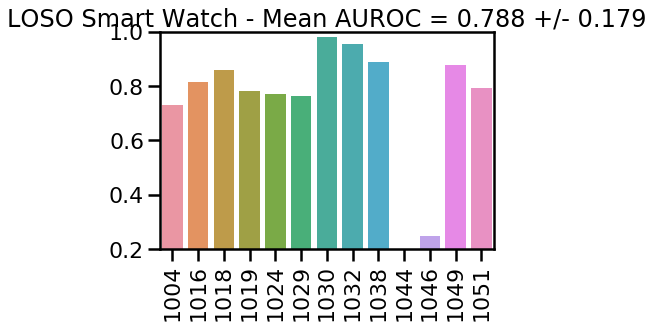

In [24]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorWatch.png',format='png',dpi=1000)

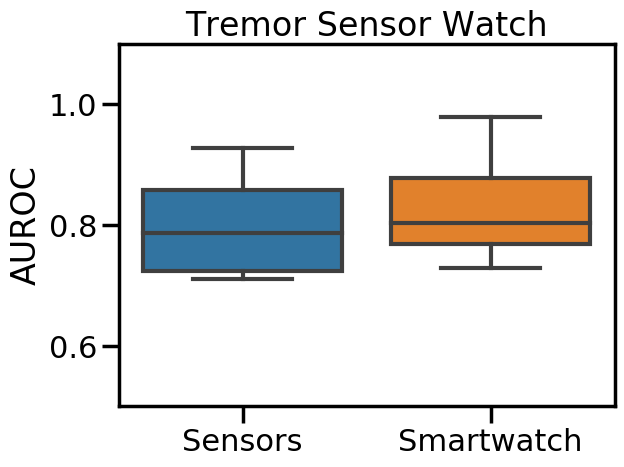

In [25]:
resultsSensor = np.load('Results/resultsTremorHand.npy')
resultsWatch = np.load('Results/resultsTremorWatch.npy')
results = pd.DataFrame({'Sensors':resultsSensor,'Smartwatch':resultsWatch})
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.5,1.1);
plt.title('Tremor Sensor Watch');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot Sensor+Watch.png',format='png',dpi=1000)

## Bradykinesia

In [26]:
#Hand Sensors

# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'

# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:79]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) | 
                        (Dataorig.Subject==1016) | 
                        (Dataorig.Subject==1018) | 
                        (Dataorig.Subject==1019) | 
#                        (Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) | 
                        (Dataorig.Subject==1029) | 
                        (Dataorig.Subject==1030) | 
                        (Dataorig.Subject==1032) | 
                        (Dataorig.Subject==1038) | 
                        (Dataorig.Subject==1044) | 
                        (Dataorig.Subject==1046) | 
                        (Dataorig.Subject==1049) | 
                        (Dataorig.Subject==1051)]

# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc'], inplace=True)

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))


    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 6697/12184 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.292,rec=0.523,Spec=0.529,auroc_train=1.000,auroc=0.531

Subj/Visit 1,prec=0.920,rec=0.751,Spec=0.642,auroc_train=1.000,auroc=0.764

Subj/Visit 2,prec=0.933,rec=0.808,Spec=0.681,auroc_train=1.000,auroc=0.762

Subj/Visit 3,prec=0.610,rec=0.938,Spec=0.286,auroc_train=1.000,auroc=0.583

Subj/Visit 4,prec=0.769,rec=0.683,Spec=0.684,auroc_train=1.000,auroc=0.741

Subj/Visit 5,prec=0.758,rec=0.630,Spec=0.718,auroc_train=1.000,auroc=0.726

Subj/Visit 6,prec=0.757,rec=0.945,Spec=0.424,auroc_train=1.000,auroc=0.746

Subj/Visit 7,prec=0.811,rec=0.621,Spec=0.469,auroc_train=1.000,auroc=0.553

Subj/Visit 8,prec=0.080,rec=0.620,Spec=0.382,auroc_train=1.000,auroc=0.473

Subj/Visit 9,prec=0.071,rec=0.776,Spec=0.441,auroc_train=1.000,auroc=0.688

Subj/Visit 10,prec=0.503,rec=0.414,Spec=0.497,auroc_train=1.000,auroc=0.465

Subj/Visit 11,prec=0.874,rec=0.393,Spec=0.590,auroc_train=1.000,auroc=0.507

Subj/Visit 12,prec=0.419

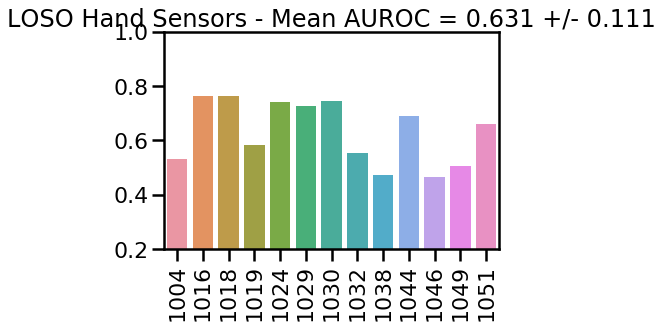

In [27]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaHand.png',format='png',dpi=1000)

In [28]:
#Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
# Dataorig.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Watch = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 5908/10692 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.426,rec=0.560,Spec=0.668,auroc_train=1.000,auroc=0.608

Subj/Visit 1,prec=0.922,rec=0.728,Spec=0.662,auroc_train=1.000,auroc=0.746

Subj/Visit 2,prec=0.926,rec=0.733,Spec=0.695,auroc_train=1.000,auroc=0.745

Subj/Visit 3,prec=0.633,rec=0.875,Spec=0.322,auroc_train=1.000,auroc=0.600

Subj/Visit 4,prec=0.696,rec=0.797,Spec=0.474,auroc_train=1.000,auroc=0.713

Subj/Visit 5,prec=0.735,rec=0.591,Spec=0.696,auroc_train=1.000,auroc=0.675

Subj/Visit 6,prec=0.645,rec=0.972,Spec=0.296,auroc_train=1.000,auroc=0.713

Subj/Visit 7,prec=0.830,rec=0.729,Spec=0.475,auroc_train=1.000,auroc=0.659

Subj/Visit 8,prec=0.073,rec=0.729,Spec=0.289,auroc_train=1.000,auroc=0.513

Subj/Visit 9,prec=0.081,rec=0.959,Spec=0.349,auroc_train=1.000,auroc=0.746

Subj/Visit 10,prec=0.514,rec=0.395,Spec=0.571,auroc_train=1.000,auroc=0.443

Subj/Visit 11,prec=0.908,rec=0.406,Spec=0.407,auroc_train=1.000,auroc=0.366

Subj/Visit 12,prec=0.405

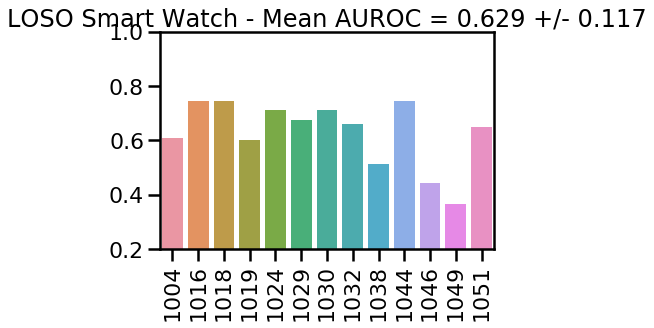

In [29]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaWatch.png',format='png',dpi=1000)

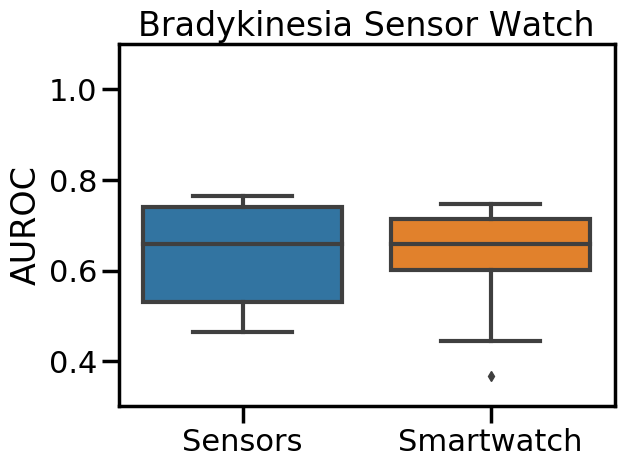

In [30]:
resultsSensor = np.load('Results/resultsBradykinesiaHand.npy')
resultsWatch = np.load('Results/resultsBradykinesiaWatch.npy')
results = pd.DataFrame({'Sensors':resultsSensor,'Smartwatch':resultsWatch})
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia Sensor Watch');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot Sensor+Watch.png',format='png',dpi=1000)

# Data Loss Comparisons

In [31]:
sensor_sample_lens = pd.read_csv('Z:CIS-PD Study\\Sensor Sample Lengths.csv',index_col=0)
watch_sample_lens = pd.read_csv('Z:CIS-PD Study\\Watch Sample Lengths.csv',index_col=0)

In [32]:
sample_lens = pd.DataFrame()
sample_lens['mean'] = pd.Series([np.mean(sensor_sample_lens['Samples']),np.mean(watch_sample_lens['Samples'])])
sample_lens['mode'] = pd.Series([mode(sensor_sample_lens['Samples']),mode(watch_sample_lens['Samples'])])
sample_lens['std'] = pd.Series([np.std(sensor_sample_lens['Samples']),np.std(watch_sample_lens['Samples'])])
sample_lens.index = ['Sensor','Watch']

sample_lens

,mean,mode,std
Sensor,311.804511,313,5.980956
Watch,248.531970,249,6.170024


# Multiclass Comparisons

# Accelerometer and Gyroscope Comparisons

## Tremor

In [33]:
# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# # Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv',index_col = 0)
# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'], inplace=True)

Dataorig = Dataorig.reset_index(drop=True)

In [34]:
#LOSO Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:79].as_matrix()
fnames = Data.iloc[:,5:79].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Accel_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.726

Subj/Visit 1,auroc=0.713

Subj/Visit 2,auroc=0.845

Subj/Visit 3,auroc=0.768

Subj/Visit 4,auroc=0.709

Subj/Visit 5,auroc=0.697

Subj/Visit 6,auroc=0.914

Subj/Visit 7,auroc=0.908

Subj/Visit 8,auroc=0.784

Subj/Visit 9,auroc=nan

Subj/Visit 10,auroc=0.312

Subj/Visit 11,auroc=0.721

Subj/Visit 12,auroc=0.763
auroc=0.738+/-0.147
Elapsed time = 1.300 min


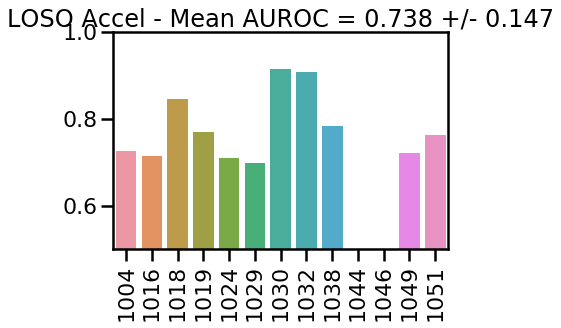

In [35]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOAccel_Hand.png',format='png',dpi=1000)

In [36]:
#LOSO Gyroscope Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,79:].as_matrix()
fnames = Data.iloc[:,79:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Gyro_Multi = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.750

Subj/Visit 1,auroc=0.793

Subj/Visit 2,auroc=0.773

Subj/Visit 3,auroc=0.765

Subj/Visit 4,auroc=0.716

Subj/Visit 5,auroc=0.736

Subj/Visit 6,auroc=0.933

Subj/Visit 7,auroc=0.917

Subj/Visit 8,auroc=0.791

Subj/Visit 9,auroc=nan

Subj/Visit 10,auroc=0.607

Subj/Visit 11,auroc=0.716

Subj/Visit 12,auroc=0.748
auroc=0.770+/-0.083
Elapsed time = 1.387 min


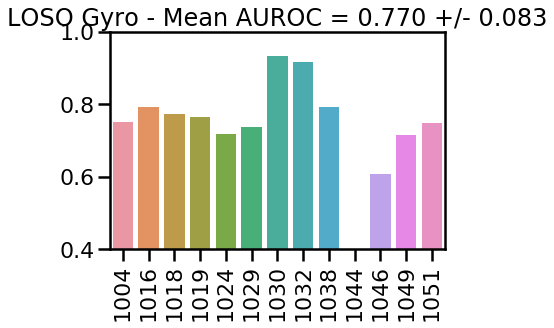

In [37]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOGyro_Hand.png',format='png',dpi=1000)

In [38]:
#LOSO Combined Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Comb_Multi = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.733

Subj/Visit 1,auroc=0.778

Subj/Visit 2,auroc=0.825

Subj/Visit 3,auroc=0.792

Subj/Visit 4,auroc=0.705

Subj/Visit 5,auroc=0.721

Subj/Visit 6,auroc=0.943

Subj/Visit 7,auroc=0.936

Subj/Visit 8,auroc=0.790

Subj/Visit 9,auroc=nan

Subj/Visit 10,auroc=0.460

Subj/Visit 11,auroc=0.732

Subj/Visit 12,auroc=0.702
auroc=0.760+/-0.119
Elapsed time = 2.024 min


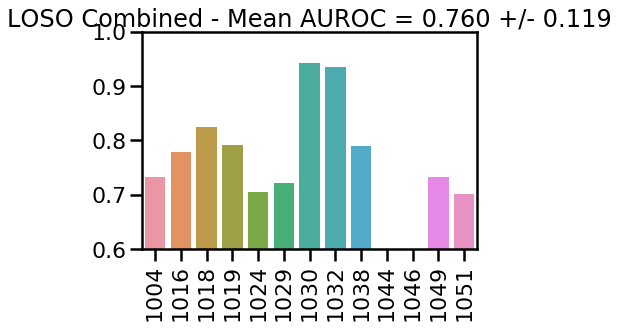

In [39]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOCombined_Hand.png',format='png',dpi=1000)

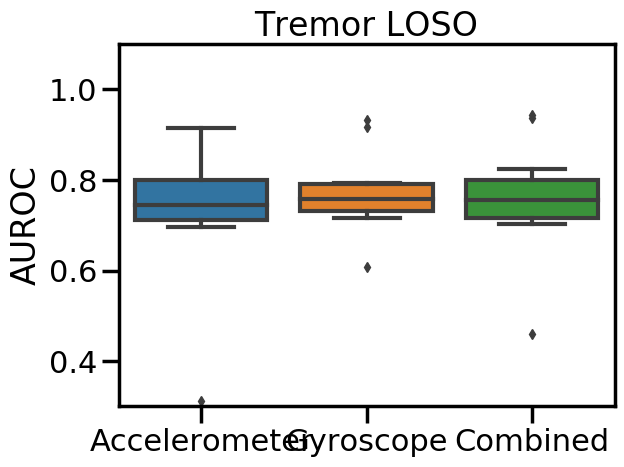

In [40]:
resultsAccel = np.load('Results/resultsTremorLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsTremorLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsTremorLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Tremor LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

## Bradykinesia

In [41]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)
# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

In [42]:
#LOSO Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:79].as_matrix()
fnames = Data.iloc[:,5:79].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Accel_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.528

Subj/Visit 1,auroc=0.674

Subj/Visit 2,auroc=0.727

Subj/Visit 3,auroc=0.627

Subj/Visit 4,auroc=0.666

Subj/Visit 5,auroc=0.654

Subj/Visit 6,auroc=0.706

Subj/Visit 7,auroc=0.602

Subj/Visit 8,auroc=0.497

Subj/Visit 9,auroc=0.787

Subj/Visit 10,auroc=0.453

Subj/Visit 11,auroc=0.510

Subj/Visit 12,auroc=0.634
auroc=0.620+/-0.095
Elapsed time = 0.962 min


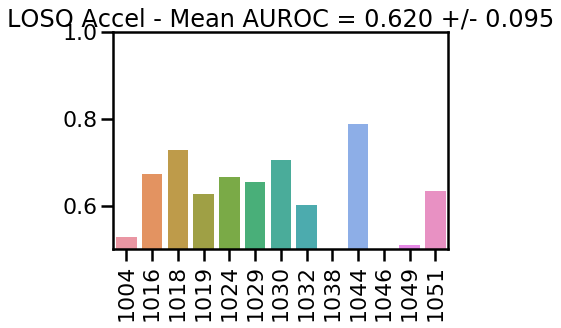

In [43]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOAccel_Hand.png',format='png',dpi=1000)

In [44]:
#LOSO Gyroscope Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,79:].as_matrix()
fnames = Data.iloc[:,79:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Gyro_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.715

Subj/Visit 1,auroc=0.747

Subj/Visit 2,auroc=0.750

Subj/Visit 3,auroc=0.628

Subj/Visit 4,auroc=0.653

Subj/Visit 5,auroc=0.583

Subj/Visit 6,auroc=0.790

Subj/Visit 7,auroc=0.643

Subj/Visit 8,auroc=0.457

Subj/Visit 9,auroc=0.789

Subj/Visit 10,auroc=0.541

Subj/Visit 11,auroc=0.486

Subj/Visit 12,auroc=0.596
auroc=0.644+/-0.106
Elapsed time = 0.989 min


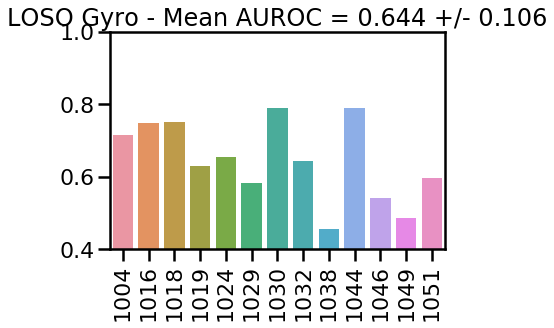

In [45]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOGyro_Hand.png',format='png',dpi=1000)

In [46]:
#LOSO Combined Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Comb_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.699

Subj/Visit 1,auroc=0.670

Subj/Visit 2,auroc=0.767

Subj/Visit 3,auroc=0.656

Subj/Visit 4,auroc=0.683

Subj/Visit 5,auroc=0.635

Subj/Visit 6,auroc=0.769

Subj/Visit 7,auroc=0.577

Subj/Visit 8,auroc=0.488

Subj/Visit 9,auroc=0.798

Subj/Visit 10,auroc=0.524

Subj/Visit 11,auroc=0.493

Subj/Visit 12,auroc=0.634
auroc=0.646+/-0.099
Elapsed time = 1.438 min


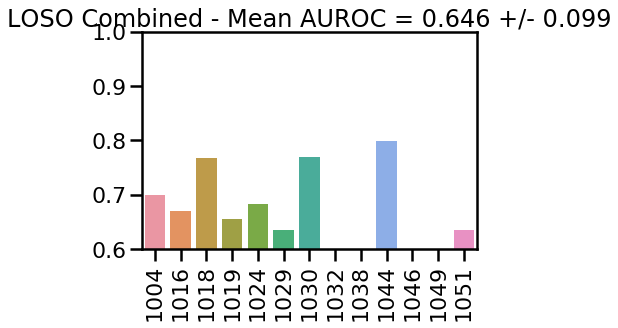

In [47]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOCombined_Hand.png',format='png',dpi=1000)

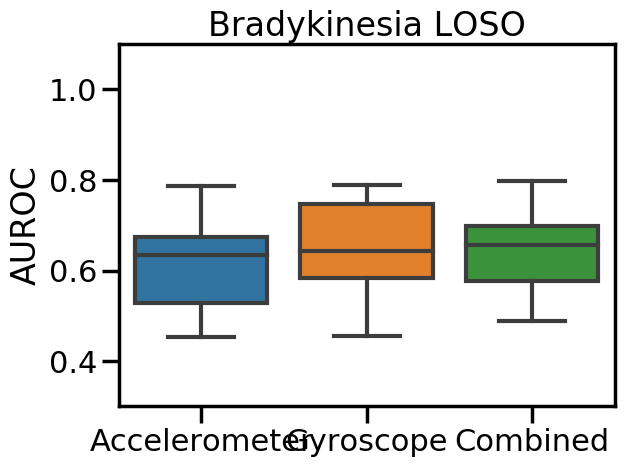

In [48]:
resultsAccel = np.load('Results/resultsBradykinesiaLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsBradykinesiaLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

# Smartwatch Comparisons

## Tremor

In [49]:
#Hand Sensors

# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'

# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:79]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) | 
                        (Dataorig.Subject==1016) | 
                        (Dataorig.Subject==1018) | 
                        (Dataorig.Subject==1019) | 
#                        (Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) | 
                        (Dataorig.Subject==1029) | 
                        (Dataorig.Subject==1030) | 
                        (Dataorig.Subject==1032) | 
                        (Dataorig.Subject==1038) | 
                        (Dataorig.Subject==1044) | 
                        (Dataorig.Subject==1046) | 
                        (Dataorig.Subject==1049) | 
                        (Dataorig.Subject==1051)]
# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc'], inplace=True)
t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.715

Subj/Visit 1,auroc=0.712

Subj/Visit 2,auroc=0.846

Subj/Visit 3,auroc=0.776

Subj/Visit 4,auroc=0.695

Subj/Visit 5,auroc=0.702

Subj/Visit 6,auroc=0.910

Subj/Visit 7,auroc=0.909

Subj/Visit 8,auroc=0.776

Subj/Visit 9,auroc=nan

Subj/Visit 10,auroc=0.339

Subj/Visit 11,auroc=0.725

Subj/Visit 12,auroc=0.782
auroc=0.741+/-0.141
Elapsed time = 1.299 min


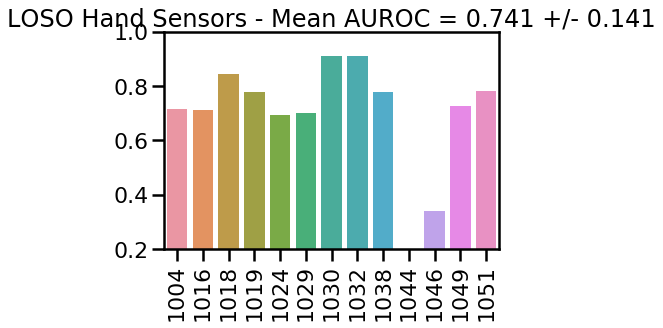

In [50]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorHand.png',format='png',dpi=1000)

In [51]:
# Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
# Dataorig.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Watch_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.719

Subj/Visit 1,auroc=0.797

Subj/Visit 2,auroc=0.858

Subj/Visit 3,auroc=0.785

Subj/Visit 4,auroc=0.739

Subj/Visit 5,auroc=0.731

Subj/Visit 6,auroc=0.976

Subj/Visit 7,auroc=0.941

Subj/Visit 8,auroc=0.760

Subj/Visit 9,auroc=nan

Subj/Visit 10,auroc=0.308

Subj/Visit 11,auroc=0.729

Subj/Visit 12,auroc=0.857
auroc=0.767+/-0.160
Elapsed time = 1.084 min


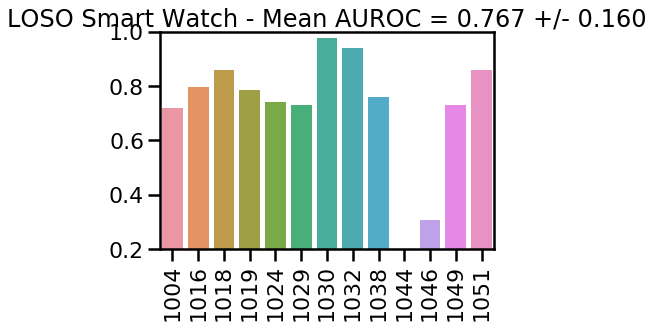

In [52]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorWatch.png',format='png',dpi=1000)

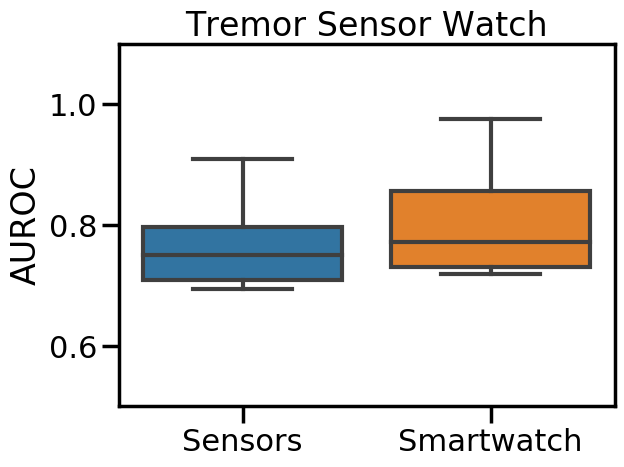

In [53]:
resultsSensor = np.load('Results/resultsTremorHand.npy')
resultsWatch = np.load('Results/resultsTremorWatch.npy')
results = pd.DataFrame({'Sensors':resultsSensor,'Smartwatch':resultsWatch})
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.5,1.1);
plt.title('Tremor Sensor Watch');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot Sensor+Watch.png',format='png',dpi=1000)

## Bradykinesia

In [54]:
#Hand Sensors

# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'

# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:79]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) | 
                        (Dataorig.Subject==1016) | 
                        (Dataorig.Subject==1018) | 
                        (Dataorig.Subject==1019) | 
#                        (Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) | 
                        (Dataorig.Subject==1029) | 
                        (Dataorig.Subject==1030) | 
                        (Dataorig.Subject==1032) | 
                        (Dataorig.Subject==1038) | 
                        (Dataorig.Subject==1044) | 
                        (Dataorig.Subject==1046) | 
                        (Dataorig.Subject==1049) | 
                        (Dataorig.Subject==1051)]
# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc'], inplace=True)
t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))


    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.530

Subj/Visit 1,auroc=0.676

Subj/Visit 2,auroc=0.742

Subj/Visit 3,auroc=0.620

Subj/Visit 4,auroc=0.662

Subj/Visit 5,auroc=0.660

Subj/Visit 6,auroc=0.729

Subj/Visit 7,auroc=0.626

Subj/Visit 8,auroc=0.483

Subj/Visit 9,auroc=0.736

Subj/Visit 10,auroc=0.445

Subj/Visit 11,auroc=0.531

Subj/Visit 12,auroc=0.632
auroc=0.621+/-0.093
Elapsed time = 0.960 min


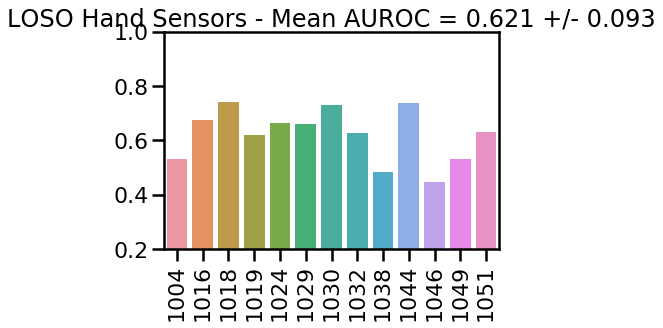

In [55]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaHand.png',format='png',dpi=1000)

In [56]:
#Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
# Dataorig.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Watch_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.559

Subj/Visit 1,auroc=0.684

Subj/Visit 2,auroc=0.722

Subj/Visit 3,auroc=0.654

Subj/Visit 4,auroc=0.663

Subj/Visit 5,auroc=0.608

Subj/Visit 6,auroc=0.573

Subj/Visit 7,auroc=0.641

Subj/Visit 8,auroc=0.541

Subj/Visit 9,auroc=0.725

Subj/Visit 10,auroc=0.457

Subj/Visit 11,auroc=0.497

Subj/Visit 12,auroc=0.601
auroc=0.610+/-0.079
Elapsed time = 0.825 min


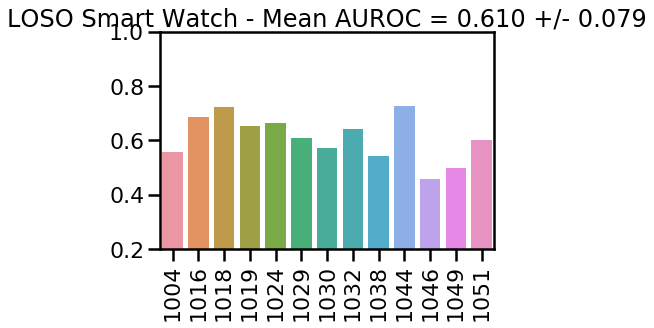

In [57]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaWatch.png',format='png',dpi=1000)

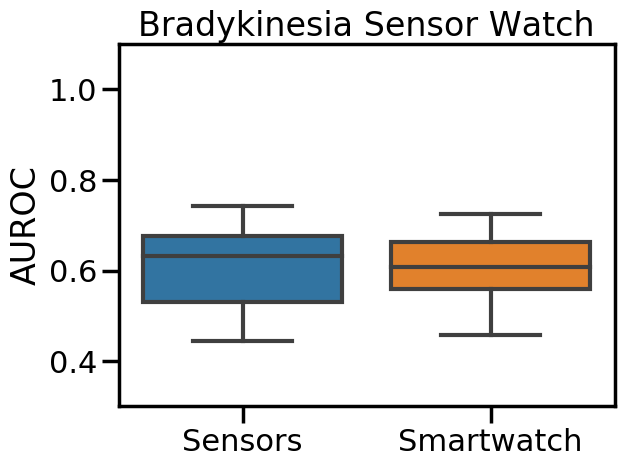

In [58]:
resultsSensor = np.load('Results/resultsBradykinesiaHand.npy')
resultsWatch = np.load('Results/resultsBradykinesiaWatch.npy')
results = pd.DataFrame({'Sensors':resultsSensor,'Smartwatch':resultsWatch})
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia Sensor Watch');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot Sensor+Watch.png',format='png',dpi=1000)

In [59]:
def pickleSave(filename,var):
    with open(filename,'wb') as handle:
        pickle.dump(var,handle)

In [60]:
varbs = [Trem_Accel,Trem_Accel_Multi,Trem_Comb,Trem_Comb_Multi,Trem_Gyro,Trem_Gyro_Multi,Trem_Watch,Trem_Watch_Multi,
         Brad_Accel,Brad_Accel_Multi,Brad_Comb,Brad_Comb_Multi,Brad_Gyro,Brad_Gyro_Multi,Brad_Watch,Brad_Watch_Multi]
files = ['Trem_Accel','Trem_Accel_Multi','Trem_Comb','Trem_Comb_Multi','Trem_Gyro','Trem_Gyro_Multi','Trem_Watch','Trem_Watch_Multi',
         'Brady_Accel','Brady_Accel_Multi','Brady_Comb','Brady_Comb_Multi','Brady_Gyro','Brady_Gyro_Multi','Brady_Watch','Brady_Watch_Multi']
for f,v in zip(files,varbs):
    pickleSave('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Results\\'+f,v)

In [61]:
d = {}
for f in files:
    with open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Results\\'+f, 'rb') as handle:
        d[f] = pickle.load(handle)
    

## Make Figures w/ ROC Curves

### Tremor

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


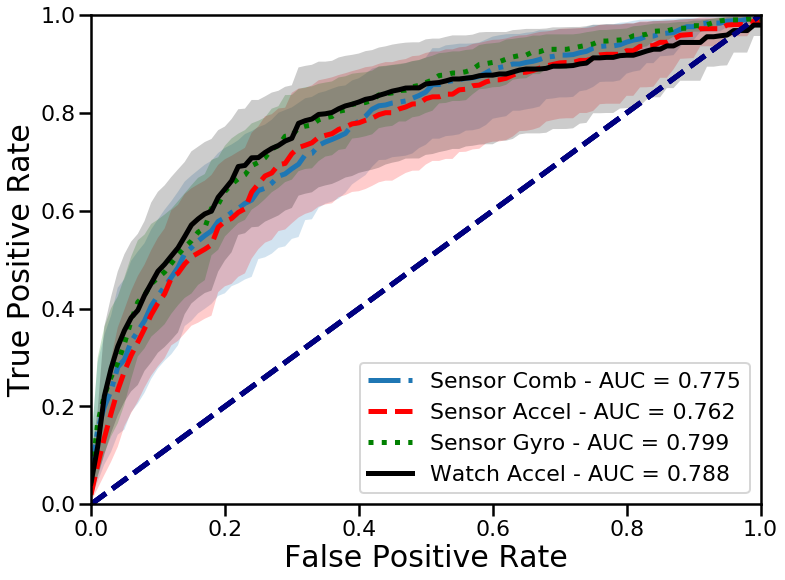

In [62]:
data = d['Trem_Comb']
plt.figure(figsize=(12,9))
lw = 5
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname='Sensor Comb',ls='-.',lw=5)
for data, c, name, ls in zip([d['Trem_Accel'],d['Trem_Gyro'],d['Trem_Watch']],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname=name,ax = ax, col = c, ls = ls,lw=5)
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Hardware\\TremorBinary.svg')

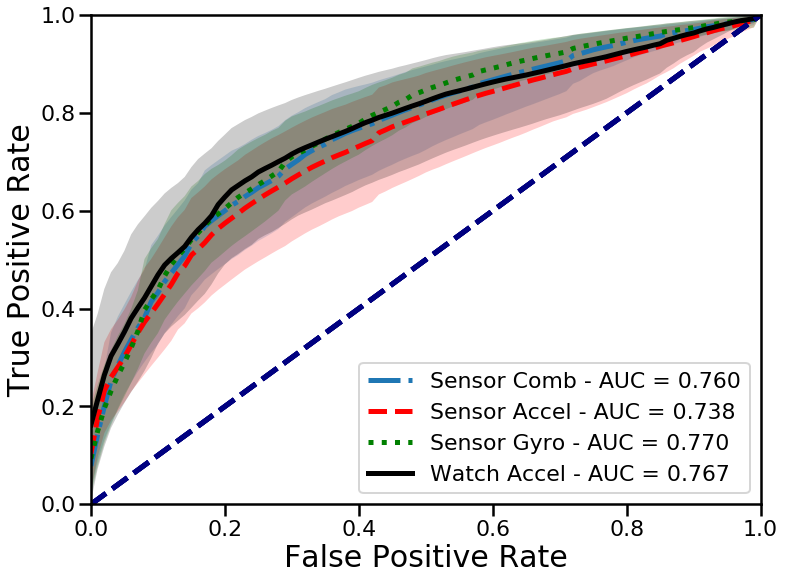

In [63]:
data = d['Trem_Comb_Multi']
plt.figure(figsize=(12,9))
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
              plotname='Sensor Comb',ls='-.',lw=lw)
for data, c, name, ls in zip([d['Trem_Accel_Multi'],d['Trem_Gyro_Multi'],d['Trem_Watch_Multi']],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname=name,ax = ax, col = c,ls = ls,lw=lw)
    
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Hardware\\TremorMulti.svg')

### Bradykinesia

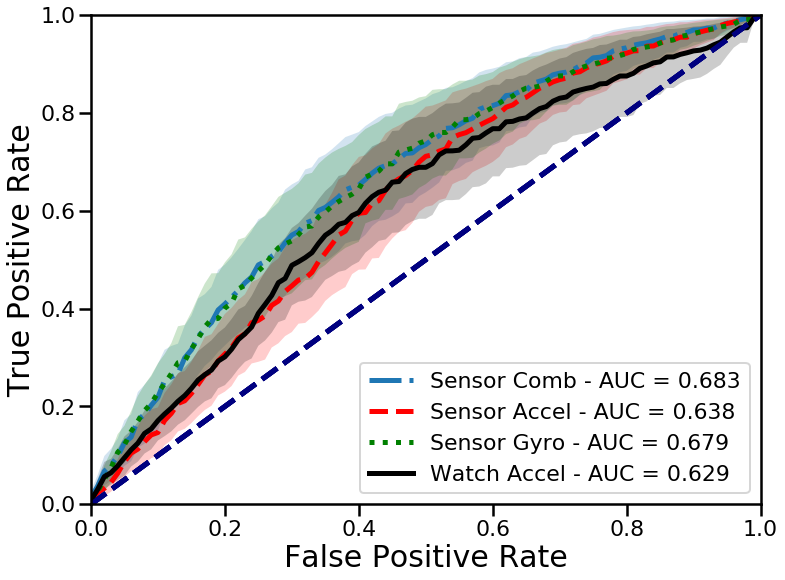

In [64]:
data = d['Brady_Comb']
plt.figure(figsize=(12,9))
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
              plotname='Sensor Comb',ls='-.',lw=lw)
for data, c, name, ls in zip([d['Brady_Accel'],d['Brady_Gyro'],d['Brady_Watch']],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname=name,ax = ax, col = c, ls=ls,lw=lw)
    
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Hardware\\BradyBinary.svg')

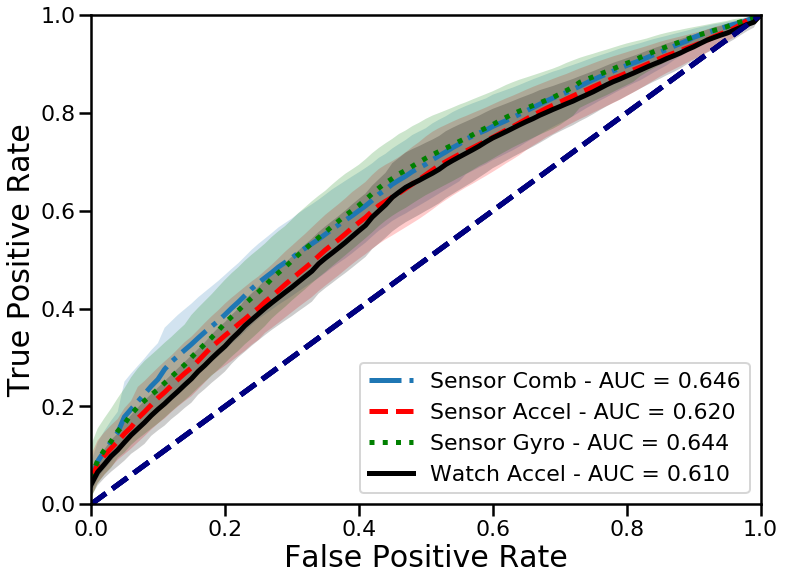

In [65]:
data = d['Brady_Comb_Multi']
plt.figure(figsize=(12,9))
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
              plotname='Sensor Comb',ls='-.',lw=lw)
for data, c, name, ls in zip([d['Brady_Accel_Multi'],d['Brady_Gyro_Multi'],d['Brady_Watch_Multi']],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']), 
             plotname = name, ax = ax, col = c,ls = ls,lw=lw)

ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Hardware\\BradyMulticlass.svg')

## Compare results

In [66]:
def PairedT(A,B):
    A = np.array(A); B = np.array(B)
    inds = np.isnan(A) | np.isnan(B)
    inds = np.array(~inds)
    return ttest_rel(A[inds],B[inds])

In [67]:
print(PairedT(Trem_Comb['auroc'],Trem_Accel['auroc']))
print(PairedT(Trem_Comb['auroc'],Trem_Gyro['auroc']))
print(PairedT(Trem_Comb['auroc'],Trem_Watch['auroc']))

Ttest_relResult(statistic=0.7728488417713517, pvalue=0.4558978706689749)
Ttest_relResult(statistic=-1.0432799776281962, pvalue=0.3192048727453672)
Ttest_relResult(statistic=-0.7584754310676098, pvalue=0.4641078719897348)


In [77]:
for v, f in zip(varbs,files):
    v = v['auroc']
    print('%s -  %.2f (%.2f-%.2f)'%(f+' '*(18-len(f)),np.nanmean(v),np.nanmean(v)-1.98*stats.sem(v,nan_policy='omit'),np.nanmean(v)+1.98*stats.sem(v,nan_policy='omit')))

Trem_Accel         -  0.76 (0.66-0.86)
Trem_Accel_Multi   -  0.74 (0.65-0.83)
Trem_Comb          -  0.77 (0.69-0.86)
Trem_Comb_Multi    -  0.76 (0.69-0.83)
Trem_Gyro          -  0.80 (0.75-0.85)
Trem_Gyro_Multi    -  0.77 (0.72-0.82)
Trem_Watch         -  0.79 (0.68-0.89)
Trem_Watch_Multi   -  0.77 (0.67-0.86)
Brady_Accel        -  0.64 (0.58-0.70)
Brady_Accel_Multi  -  0.62 (0.57-0.67)
Brady_Comb         -  0.68 (0.62-0.75)
Brady_Comb_Multi   -  0.65 (0.59-0.70)
Brady_Gyro         -  0.68 (0.61-0.74)
Brady_Gyro_Multi   -  0.64 (0.58-0.71)
Brady_Watch        -  0.63 (0.56-0.70)
Brady_Watch_Multi  -  0.61 (0.56-0.65)


In [69]:
def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[i])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return F,stats.f.sf(F,dfbw,dferror)

In [70]:
def HBCorrections(vs,fs,target=.05):
    res = []
    for pair in itertools.combinations([(v['auroc'],f) for v,f in zip(vs,fs)],2):
        f_pair = [pair[0][1],pair[1][1]]
        if (fs[0] not in f_pair) and ((fs[1] not in f_pair) or fs[3] not in f_pair):
            continue
        p = PairedT(pair[0][0], pair[1][0])[1]
        res.append((p,pair[0][1]+'+'+pair[1][1]))
    
    res = sorted(res)
    dec = 'Reject'
    for r,i in zip(res,range(1,len(res)+1)):
        thresh = target/(len(res)-i+1)
        if r[0]<thresh and dec=='Reject':
            dec = 'Reject'
        else:
            dec = 'Accept'
        print('%s\t%.3f\t%.3f\t%s'%(r[1],r[0],thresh,dec))

In [80]:
vs, fs = [Trem_Comb, Trem_Accel, Trem_Gyro, Trem_Watch], ['Trem_Combo', 'Trem_Accel', 'Trem_Gyro', 'Trem_Watch']
df = pd.DataFrame(data = np.vstack([v['auroc'] for v in vs]).transpose(), columns = fs).dropna()
rmANOVA(df,fs)

(0.9558757421068774, 0.4250386692085034)

In [72]:
vs, fs = [Trem_Comb_Multi, Trem_Accel_Multi, Trem_Gyro_Multi, Trem_Watch_Multi], ['Trem_Combo_Multi', 'Trem_Accel_Multi', 'Trem_Gyro_Multi', 'Trem_Watch_Multi']
df = pd.DataFrame(data = np.vstack([v['auroc'] for v in vs]).transpose(), columns = fs).dropna()
rmANOVA(df,fs)

(1.0163919375960146, 0.39787485434953934)

In [73]:
vs, fs = [Brad_Comb, Brad_Accel, Brad_Gyro, Brad_Watch], ['Brad_Combo', 'Brad_Accel', 'Brad_Gyro', 'Brad_Watch']
df = pd.DataFrame(data = np.vstack([v['auroc'] for v in vs]).transpose(), columns = fs).dropna()
rmANOVA(df,fs)

(4.344880133074938, 0.010337368122383499)

In [74]:
HBCorrections(vs,fs)

Brad_Combo+Brad_Watch	0.001	0.013	Reject
Brad_Combo+Brad_Accel	0.008	0.017	Reject
Brad_Accel+Brad_Watch	0.641	0.025	Accept
Brad_Combo+Brad_Gyro	0.817	0.050	Accept


In [75]:
vs, fs = [Brad_Comb_Multi, Brad_Accel_Multi, Brad_Gyro_Multi, Brad_Watch_Multi], ['Brad_Combo_Multi', 'Brad_Accel_Multi', 'Brad_Gyro_Multi', 'Brad_Watch_Multi']
df = pd.DataFrame(data = np.vstack([v['auroc'] for v in vs]).transpose(), columns = fs).dropna()
rmANOVA(df,fs)

(2.1193876938722065, 0.1148452242279475)

In [76]:
HBCorrections(vs,fs)

Brad_Combo_Multi+Brad_Watch_Multi	0.098	0.013	Accept
Brad_Combo_Multi+Brad_Accel_Multi	0.115	0.017	Accept
Brad_Accel_Multi+Brad_Watch_Multi	0.443	0.025	Accept
Brad_Combo_Multi+Brad_Gyro_Multi	0.922	0.050	Accept


In [210]:
[' ']*(20-len(f))

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

In [178]:
np.isnan(A)

array([False, False, False, False, False, False, False, False, False,
        True, False, False, False])

In [174]:
Trem_Comb['auroc'][np.array([[True,  True,  True,  True,  True,  True,  True,  True,  True, False, True, True, True]])]

TypeError: only integer scalar arrays can be converted to a scalar index

In [257]:
mc = MultiComparison(df.values.flatten(),np.hstack([np.array([c]*len(df[c])) for c in df.columns.values]))
results = mc.tukeyhsd()

In [259]:
print(results)

 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1     group2   meandiff  lower  upper  reject
----------------------------------------------------
Brad_Accel Brad_Combo  0.0322  -0.1232 0.1876 False 
Brad_Accel Brad_Gyro   0.0369  -0.1185 0.1923 False 
Brad_Accel Brad_Watch -0.0953  -0.2507 0.0601 False 
Brad_Combo Brad_Gyro   0.0047  -0.1507 0.1601 False 
Brad_Combo Brad_Watch -0.1275  -0.2829 0.0279 False 
Brad_Gyro  Brad_Watch -0.1323  -0.2876 0.0231 False 
----------------------------------------------------


In [251]:
np.hstack([np.array([c]*len(v['auroc'])) for c,v in zip(df.columns.values,vs)])

array(['Brad_Combo', 'Brad_Combo', 'Brad_Combo', 'Brad_Combo',
       'Brad_Combo', 'Brad_Combo', 'Brad_Combo', 'Brad_Combo',
       'Brad_Combo', 'Brad_Combo', 'Brad_Combo', 'Brad_Combo',
       'Brad_Combo', 'Brad_Accel', 'Brad_Accel', 'Brad_Accel',
       'Brad_Accel', 'Brad_Accel', 'Brad_Accel', 'Brad_Accel',
       'Brad_Accel', 'Brad_Accel', 'Brad_Accel', 'Brad_Accel',
       'Brad_Accel', 'Brad_Accel', 'Brad_Gyro', 'Brad_Gyro', 'Brad_Gyro',
       'Brad_Gyro', 'Brad_Gyro', 'Brad_Gyro', 'Brad_Gyro', 'Brad_Gyro',
       'Brad_Gyro', 'Brad_Gyro', 'Brad_Gyro', 'Brad_Gyro', 'Brad_Gyro',
       'Brad_Watch', 'Brad_Watch', 'Brad_Watch', 'Brad_Watch',
       'Brad_Watch', 'Brad_Watch', 'Brad_Watch', 'Brad_Watch',
       'Brad_Watch', 'Brad_Watch', 'Brad_Watch', 'Brad_Watch',
       'Brad_Watch'], dtype='<U10')

In [244]:
df.values.transpose()

array([[0.79192893, 0.77557218, 0.8247755 , 0.80144081, 0.70710601,
        0.73123974, 0.92914052, 0.94253186, 0.8745948 , 0.3941006 ,
        0.87490622, 0.74491646],
       [0.54827063, 0.74885027, 0.77508361, 0.63365633, 0.7601761 ,
        0.71411962, 0.72805935, 0.52972214, 0.50972489, 0.44588465,
        0.5122442 , 0.65632207],
       [0.79548898, 0.78392352, 0.80058115, 0.76590898, 0.72154387,
        0.75859073, 0.93495345, 0.93585002, 0.87083411, 0.56116887,
        0.86809409, 0.83855718],
       [0.59742852, 0.75144316, 0.71735418, 0.53726818, 0.73282206,
        0.66056529, 0.64775691, 0.60067538, 0.46376954, 0.47245189,
        0.3732468 , 0.6386631 ]])

# Accelerometer and EMG comparisons

In [7]:
Data_accel = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data 62.5Hz.csv')
Data_EMG = pd.read_csv('Z:CIS-PD Study\MotorTasks EMG Data.csv',index_col=0).iloc[:,6:]

Datafull = pd.DataFrame
Data_accel = Data_accel.reset_index(drop=True)
Data_EMG = Data_EMG.reset_index(drop=True)
Datafull = pd.concat((Data_accel.iloc[:,:6],Data_EMG,Data_accel.iloc[:,13]),axis=1)

In [8]:
Datafull.head()

,Unnamed: 0,Subject,Visit,Task,Bradykinesia,Tremor,RMS0,mean0,var0,skew0,...,MAV9,RMS10,mean10,var10,skew10,kurt10,binen10,energy10,MAV10,meanY
0,0.0,1004.0,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000593
1,1.0,1004.0,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000049
2,2.0,1004.0,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000050
3,3.0,1004.0,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000058,0.000129,0.000009,0.399398,...,0.000002,1.818105e-08,4.014991e-09,9.088620e-07,-0.036244,1.759811,2.024107,2.064290e-09,6.495575e-07,0.000045
4,4.0,1004.0,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000201


In [9]:
s = 'flexor_digitorum__accel'
print('%s,discarded %d rows'%(s,sum(Datafull[s].apply(type) == float)))
Datafull = Datafull[Datafull[s].apply(type) != float]

s = 'Tremor'
print('%s,discarded %d rows'%(s,sum(np.isnan(Datafull[s]))))
Datafull = Datafull[~np.isnan(Datafull[s])]

s = Data_EMG.columns.values[6]
print('%s,discarded %d rows'%(s,sum(np.isnan(Datafull[s]))))
Datafull = Datafull[~np.isnan(Datafull[s])]

KeyError: 'flexor_digitorum__accel'

In [ ]:
def feature_unpack_forearm(Datafull):
    #unpack features
    colnames_accel =['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
           'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
           'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
           'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
           'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
           'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']
    colnames_accel =[i+' accel' for i in colnames_accel]

    sensor = 'flexor_digitorum__accel'
    
    Datafinal = pd.DataFrame()
    
    for i in range(len(Datafull)):
        F = Datafull[sensor].iloc[i]
        F = pd.DataFrame(data=F.reshape(-1,1).T,index=[i],columns=colnames_accel)
        Datafinal = pd.concat((Datafinal,F))
    Datafinal=Datafinal.reset_index(drop=True)
    Datafull=Datafull.reset_index(drop=True)
    Datafinal = pd.concat((Datafull.iloc[:,:94],Datafinal),axis=1)

    return Datafinal

In [ ]:
Datafull = feature_unpack_forearm(Datafull)

In [ ]:
Datafull.head()

## Leave One Subject Out

### Tremor

In [ ]:
#LOSO EMG Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:94].as_matrix()
fnames = Data.iloc[:,6:94].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOEMG.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.25,0.65])
plt.title('LOSO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOEMG.png',format='png',dpi=1000)

In [ ]:
#LOSO Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,94:].as_matrix()
fnames = Data.iloc[:,94:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOAccel.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.55,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOAccel.png',format='png',dpi=1000)

In [ ]:
#LOSO Combined EMG and Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:].as_matrix()
fnames = Data.iloc[:,6:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOCombined.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,0.95])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOCombined.png',format='png',dpi=1000)

In [ ]:
resultsEMG = np.load('Results/resultsTremorLOSOEMG.npy')
resultsAccel = np.load('Results/resultsTremorLOSOAccel.npy')
resultsCombined = np.load('Results/resultsTremorLOSOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Tremor LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOSO.png',format='png',dpi=1000)

### Bradykinesia

In [ ]:
#LOSO EMG Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:94].as_matrix()
fnames = Data.iloc[:,6:94].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOEMG.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.25,0.65])
plt.title('LOSO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOEMG.png',format='png',dpi=1000)

In [ ]:
#LOSO Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,94:].as_matrix()
fnames = Data.iloc[:,94:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOAccel.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.45,0.85])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOAccel.png',format='png',dpi=1000)

In [ ]:
#LOSO Combined EMG and Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:].as_matrix()
fnames = Data.iloc[:,6:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOCombined.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,0.95])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOCombined.png',format='png',dpi=1000)

In [ ]:
resultsEMG = np.load('Results/resultsBradykinesiaLOSOEMG.npy')
resultsAccel = np.load('Results/resultsBradykinesiaLOSOAccel.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOSOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOSO.png',format='png',dpi=1000)

## Leave One Visit Out

### Tremor

In [ ]:
#LOVO EMG Tremor

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:94]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsTremorLOVOEMG.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    tremor_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.2,0.9])

plt.savefig('Results/resultsTremorLOVOEMG.png',format='png',dpi=1000)

In [ ]:
#LOVO Accelerometer Tremor

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,94:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsTremorLOVOAccel.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    tremor_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.5,1.1])

plt.savefig('Results/resultsTremorLOVOAccel.png',format='png',dpi=1000)

In [ ]:
#LOVO Combined Tremor

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsTremorLOVOCombined.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    tremor_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.3,1.1])

plt.savefig('Results/resultsTremorLOVOCombined.png',format='png',dpi=1000)

In [ ]:
resultsEMG = np.load('Results/resultsTremorLOVOEMG.npy')
resultsAccel = np.load('Results/resultsTremorLOVOAccel.npy')
resultsCombined = np.load('Results/resultsTremorLOVOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.2,1.1);
plt.title('Tremor LOVO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOVO.png',format='png',dpi=1000)

### Bradykinesia

In [ ]:
#LOVO EMG Bradykinesia

symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:94]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsBradykinesiaLOVOEMG.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    brady_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.3,1.0])

plt.savefig('Results/resultsBradykinesiaLOVOEMG.png',format='png',dpi=1000)

In [ ]:
#LOVO Accelerometer Bradykinesia

symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,94:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsBradykinesiaLOVOAccel.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    brady_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.5,1.1])

plt.savefig('Results/resultsBradykinesiaLOVOAccel.png',format='png',dpi=1000)

In [ ]:
#LOVO Combined Bradykinesia

symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsBradykinesiaLOVOCombined.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    brady_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1.1])

plt.savefig('Results/resultsBradykinesiaLOVOCombined.png',format='png',dpi=1000)

In [ ]:
resultsEMG = np.load('Results/resultsBradykinesiaLOVOEMG.npy')
resultsAccel = np.load('Results/resultsBradykinesiaLOVOAccel.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOVOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.4,1.1);
plt.title('Bradykinesia LOVO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOVO.png',format='png',dpi=1000)